This notebook performs the synthesis using our proposed synthesization approach applied to the South Korean COVID-19 Patient data. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

Number of locations from deceased individuals.

In [3]:
np.sum(train_data.state)

55

In [4]:
np.mean(train_data.sex)

0.4620083432657926

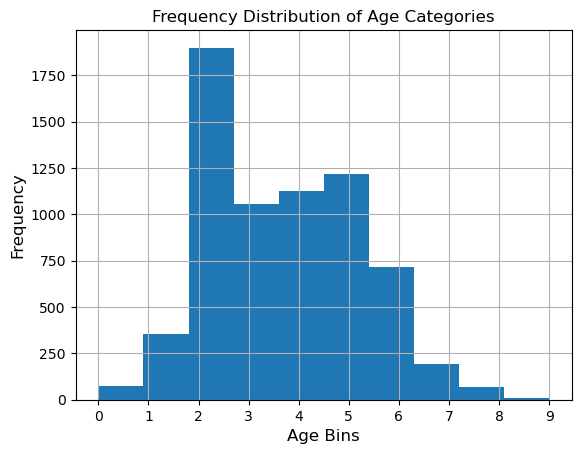

In [5]:
ax = train_data.age.plot.hist(grid=True, bins=10)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Age Bins', fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
plt.title("Frequency Distribution of Age Categories")
plt.show()

***

Testing logistic and multinomial logistic regression synthesizers.

In [6]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [7]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_sex_": (0.001, 3),
            "C_age_": (0.001, 3),
            "C_state_": (0.001, 3)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [8]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [9]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.2579   | 2.23      | 0.68      | 1.928     | 178.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.2287   | 2.222     | 2.164     | 0.8867    | 110.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.2088   | 0.5221    | 2.436     | 2.548     | 58.99     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.2321   | 0.7125    | 1.376     | 0.6875    | 48.58     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.2201   | 2.948     | 2.942     | 2.205     | 88.17     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.2135   | 1.486     | 2.178     | 2.027     | 179.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.2495   | 0.6938    | 2.932     | 2.859     | 29.79     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.2336   | 0.9362    | 2.843     | 2.614     | 105.2     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1175   | 0.8349    | 1.203     | 0.3184    | 29.35     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.123    | 2.128     | 0.6103    | 0.3872    | 133.9     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.003137 | 0.6789    | 1.145     | 0.06627   | 29.13     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.2341   | 1.341     | 1.132     | 2.848     | 87.31     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.1617   | 0.7528    | 0.7346    | 0.4276    | 49.72     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.2367   | 1.315     | 1.656     | 1.59      | 36.28     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.001022 | 0.7632    | 1.103     | 0.02935   | 29.03     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -3.762    | 0.5535    | 1.1       | 0.001     | 28.95     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.2917   | 2.369     | 0.7901    | 0.5949    | 198.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.2459   | 1.36      | 1.138     | 1.091     | 51.26     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.2211   | 1.559     | 1.214     | 1.046     | 51.41     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.1207   | 0.8139    | 1.247     | 0.3531    | 29.31     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.2646   | 2.362     | 2.111     | 0.8711    | 110.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.1776   | 0.8221    | 0.7658    | 0.3411    | 49.66     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.2865   | 2.713     | 2.563     | 2.663     | 38.75     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.2216   | 0.5597    | 0.6877    | 2.212     | 30.74     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.0253   | 0.7715    | 1.13      | 0.06174   | 29.11     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.2391   | 0.5909    | 1.162     | 2.206     | 109.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.1325   | 2.078     | 0.6102    | 0.254     | 133.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1297   | 2.027     | 0.6992    | 0.3668    | 133.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.2359   | 1.21      | 1.465     | 1.402     | 189.3     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.2684   | 1.469     | 2.998     | 1.259     | 42.01     |
Final Result:  {'target': -0.0010217635697143096, 'params': {'C_age_': 0.7632117153701964, 'C_sex_': 1.102831943823116, 'C_state_': 0.0293546585580681, 'num_components_': 29.031567562073736}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.2237   | 2.455     | 2.623     | 1.256     | 95.03     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.2539   | 0.3865    | 0.3158    | 1.939     | 193.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.2254   | 0.873     | 0.2011    | 1.478     | 86.85     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.2045   | 0.6546    | 2.504     | 0.5472    | 89.95     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.06364  | 0.929     | 2.961     | 0.1235    | 66.4      |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

| 6         | -2.242    | 0.8128    | 3.0       | 0.001     | 61.45     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.09784  | 0.8286    | 2.885     | 0.193     | 67.23     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.2928   | 2.412     | 0.4875    | 2.017     | 91.49     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

| 9         | -1.827    | 3.0       | 3.0       | 0.001     | 67.12     |
| 10        | -0.007743 | 0.02986   | 2.9       | 0.2156    | 66.65     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 11        | -1.887    | 0.2497    | 1.602     | 0.001     | 66.63     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.1693   | 0.5055    | 3.0       | 0.4117    | 66.74     |
| 13        | -3.606    | 0.1353    | 3.0       | 0.001     | 66.07     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.1948   | 0.9491    | 2.599     | 0.735     | 90.14     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.1678   | 0.7781    | 2.452     | 0.7639    | 90.02     |
| 16        | -0.01982  | 0.02994   | 2.9       | 0.2157    | 66.65     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.265    | 1.013     | 0.4315    | 1.449     | 86.85     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.1845   | 0.3784    | 0.1769    | 1.885     | 193.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.1721   | 0.7739    | 0.1271    | 1.665     | 86.65     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.1903   | 1.191     | 0.5702    | 2.751     | 137.1     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.2154   | 2.599     | 2.544     | 1.134     | 94.92     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.01271  | 0.8081    | 2.237     | 0.0687    | 145.9     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.1564   | 0.9104    | 2.726     | 0.25      | 66.37     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.2538   | 2.18      | 2.33      | 0.8274    | 199.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.2091   | 0.2763    | 0.4041    | 1.921     | 167.9     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.1716   | 0.7096    | 0.3409    | 0.3692    | 107.2     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.1374   | 2.085     | 1.331     | 0.535     | 149.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1954   | 2.893     | 2.979     | 0.6242    | 146.0     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.09346  | 0.991     | 2.52      | 0.2005    | 66.42     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.28     | 0.8834    | 0.1944    | 1.65      | 86.96     |
Final Result:  {'target': -0.007742882167453857, 'params': {'C_age_': 0.02986120912042889, 'C_sex_': 2.899630806346623, 'C_state_': 0.2156147990885149, 'num_components_': 66.6460555850756}}


In [10]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

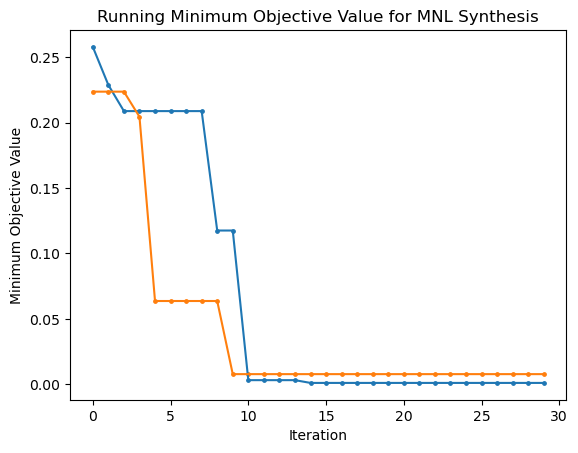

In [11]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [12]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [13]:
best_params

{'target': -0.0010217635697143096,
 'params': {'C_age_': 0.7632117153701964,
  'C_sex_': 1.102831943823116,
  'C_state_': 0.0293546585580681,
  'num_components_': 29.031567562073736}}

Generate 20 synthetic data sets.

In [14]:
full_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for MNL, end with underscore means Bayesian optimization will choose
                                             C_sex_=best_params['params']['C_sex_'],
                                             C_age_=best_params['params']['C_age_'],
                                             C_state_=best_params['params']['C_state_'])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
np.mean(full_ratios)

1.0696218334374947

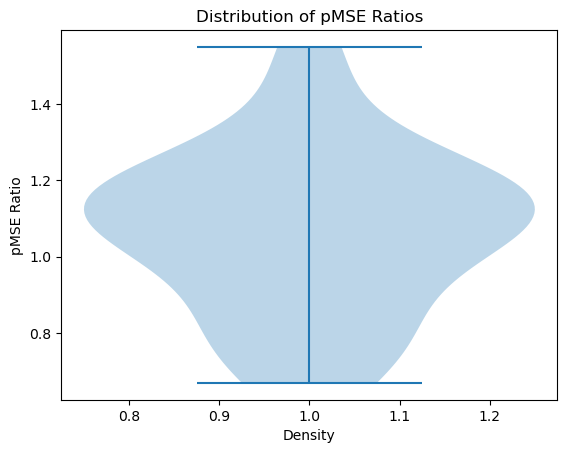

In [16]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [17]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)

***

In [18]:
full_sXs = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

Now apply the attribute disclosure prevention algorithm.

Based on publicly available data from the World Health Organization, we use the total number of confirmed COVID-19 cases (9,583) and total number of deaths (152) in South Korea as of March 23, 2020 to calculate the prior probability $p(S_j = 1 | x_j^q, b) = 152/9583 \approx 0.016$ and $p(S_j = 0 | x_j^q, b) = 1 - 0.016 = 0.984$.

In [19]:
prior = 152/9583

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the correct disease status based on the synthetic data. This is a relatively large increase. For example, this means going from 0.016 under the prior to no more than 0.16 under the updated probability.

In [20]:
c = 10

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [21]:
deltas = np.linspace(0.001, 1, 5)

In [22]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['latitude', 'longitude'],
                                         categorical_vars=['sex', 'age'],
                                         sensitive_var='state',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


In [23]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)